In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [3]:
import pandas as pd
import numpy as np

In [4]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [5]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [6]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()
the_df = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "SCHU"]
# the_df = the_df[the_df['lead_time_HOUR']==2]

All init times, with the 2 hour (or n hour) forecast to build your dataframe for training 

Temp:
rad 
tcc
rel h
d2m 
t2m
udir
umag
geo potential height 
snow_depth

precip:
cape


In [7]:
the_df.head()

,station,valid_time,time,t2m_HRRR,d2m_HRRR,u_total_HRRR,u_dir_HRRR,latitude,longitude,new_tp_HRRR,...,mslma_error,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,mslma_nysm,lead_time_DAY,lead_time_HOUR,lead_time_ONLY_HOURS
46874,SCHU,2018-01-01 14:00:00,2018-01-01 12:00:00,-26.027145,-28.905670,0.644868,187.528809,43.110052,-73.591823,0.000,...,2.682983,-25.742041,-28.596741,1.591372,210.035599,0.0,1025.776978,0,2,2.0
46891,SCHU,2018-01-02 14:00:00,2018-01-02 12:00:00,-21.528107,-25.467850,0.877086,183.995544,43.110052,-73.591823,0.000,...,1.876099,-24.971720,-27.329132,0.426544,148.757996,0.0,1025.303955,0,2,2.0
46909,SCHU,2018-01-03 14:00:00,2018-01-03 12:00:00,-13.518524,-17.244980,1.177225,197.045898,43.110052,-73.591823,0.000,...,1.684998,-13.528000,-16.917023,0.901959,143.990997,0.0,1022.085022,0,2,2.0
46927,SCHU,2018-01-04 14:00:00,2018-01-04 12:00:00,-9.118805,-11.006927,4.044873,343.826569,43.110052,-73.591823,0.526,...,2.140991,-9.761938,-15.158356,1.489278,339.939209,0.0,1004.369019,0,2,2.0
46945,SCHU,2018-01-05 14:00:00,2018-01-05 12:00:00,-17.372955,-22.803909,2.213601,214.468658,43.110052,-73.591823,0.000,...,3.331970,-16.234230,-24.080521,2.972355,250.703903,0.0,1001.148010,0,2,2.0


In [8]:
the_df.keys()

Index(['station', 'valid_time', 'time', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR',
       'u_dir_HRRR', 'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR',
       'orog', 't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [8]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

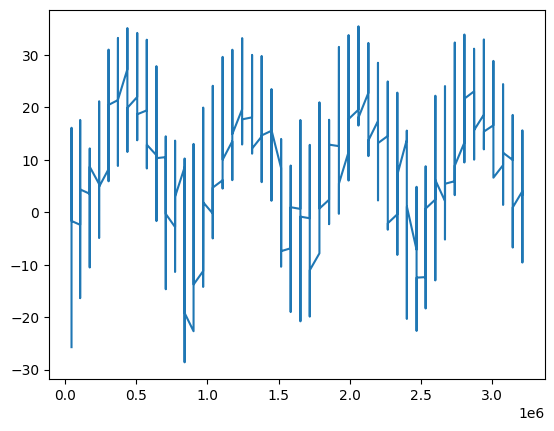

In [9]:
import matplotlib.pyplot as plt


plt.plot(the_df["t2m_nysm"])

Isolate one NYSM station and drop unnecessary columns 

In [277]:
hrrr_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_HRRR', 'd2m_HRRR', 'u_total_HRRR',
       'u_dir_HRRR', 'latitude', 'longitude', 'new_tp_HRRR', 'mslma_HRRR',
       'orog', 't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'mslma_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'mslma_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [278]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.drop(
    columns=[
        "station",
        "valid_time",
        "time",
        "lead_time_DAY",
        "lead_time_HOUR",
        "lead_time_ONLY_HOURS",
        "t2m_error",
        "d2m_error",
        "u_total_error",
        "u_dir_error",
        "new_tp_error",
        "mslma_error",
    ]
)

Create your target variable, and create a target variable column. The newly created target column won’t have values in the final 12 rows, so we’ll drop those

In [279]:
target_sensor = "t2m_nysm"
features = list(hrrr_fcast_and_error_df.columns.difference([target_sensor]))

forecast_lead = 12
target = f"{target_sensor}_lead_{forecast_lead}"

hrrr_fcast_and_error_df[target] = hrrr_fcast_and_error_df[target_sensor].shift(
    -forecast_lead
)
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.iloc[:-forecast_lead]

Create and hold out a test set

In [280]:
test_start = 19563

df_train = hrrr_fcast_and_error_df.iloc[:19563].copy()
df_test = hrrr_fcast_and_error_df.iloc[19563:].copy()

print("Test set fraction:", len(df_test) / len(hrrr_fcast_and_error_df))

Test set fraction: 0.2495108758200023


Standardize your features and target

In [281]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

create a PyTorch Dataset class, which is simpler than you might think. This strategy lets us lean on PyTorch’s nice DataLoader class to keep the model training and evaluation code super clean.

Our custom Dataset just needs to specify what happens when somebody requests the i’th element of the dataset. In a tabular dataset, this would be the i’th row of the table, but here we need to retrieve a sequence of rows.

So, given i and the sequence_length, we return the block of data from i - sequence_length through row i. If i is at the beginning of the dataset, we pad by repeating the first row as many times as needed to make the output have sequence_length rows. The only trick is avoiding off-by-1 errors in the slicing and padding.

All the magic happens in the __getitem__ method in this snippet.

In [282]:
import torch
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [283]:
# Let’s look at a small example to build intuition about how it works. Namely, let’s grab the 27’th entry in the dataset with a sequence length of 4.

i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4497e+00, -1.7762e+00, -5.4111e-04,  8.1898e-04,  8.1243e-01,
          7.0300e-01, -1.4117e-01, -1.6911e-01, -1.7071e-01, -1.4175e+00,
          1.4362e-02, -1.9943e-01,  4.9968e-01,  7.9216e-01],
        [-1.6018e+00, -1.8553e+00, -5.4111e-04,  8.1898e-04,  7.6328e-01,
          6.7636e-01, -1.4117e-01, -1.6911e-01, -1.7071e-01, -1.4504e+00,
          1.2149e-01,  4.2872e-01,  6.4749e-01, -8.6320e-01],
        [-1.6355e+00, -1.8701e+00, -5.4111e-04,  8.1898e-04,  7.6208e-01,
          6.9691e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.4876e+00,
          1.4533e-01, -1.6451e+00,  1.1574e+00, -1.0197e+00],
        [-1.7131e+00, -1.9066e+00, -5.4111e-04,  8.1898e-04,  8.2801e-01,
          7.3967e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.5212e+00,
          1.6765e-01, -1.0365e+00,  1.5842e+00, -1.1782e+00]])


The next step is to set the dataset in a PyTorch DataLoader, which will draw minibatches of data for us. Let’s try a small batch size of 3, to illustrate.

In [284]:
from torch.utils.data import DataLoader

torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 14])
tensor([[[-3.3778e-01, -3.6806e-01, -5.4111e-04,  8.1898e-04,  8.1483e-01,
           8.6652e-01, -1.4846e-01, -1.6911e-01, -1.7071e-01, -5.4937e-01,
           2.3856e-02,  6.4612e-02, -1.3065e+00, -3.4168e-01],
         [-2.3539e-01, -3.7836e-01, -5.4111e-04,  8.1898e-04,  7.3810e-01,
           8.5266e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -3.0239e-01,
          -3.2976e-01, -3.2410e-02, -8.9517e-01,  7.4691e-02],
         [-1.3541e-01, -3.7558e-01, -5.4111e-04,  8.1898e-04,  7.2852e-01,
           8.4024e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01, -1.2657e-01,
          -2.9962e-01,  4.4794e-02,  1.3613e-01,  2.4120e-01],
         [-2.6292e-02, -3.4369e-01, -5.4111e-04,  8.1898e-04,  6.3860e-01,
           7.7132e-01, -1.5332e-01, -1.6911e-01, -1.7071e-01,  5.6822e-02,
          -3.7254e-01, -3.1139e-03,  9.8118e-01,  6.8673e-01]],

        [[-1.3320e+00, -1.3771e+00, -5.4111e-04,  8.1898e-04,  1.5377e+00,
           1.5871e+00, -1.5332e-01, -1.6911e-01,

with a sequence of 48 time steps. For training, we’ll shuffle the data (the rows within each data sequence are not shuffled, only the order in which we draw the blocks). For the test set, shuffling isn’t necessary.

In [285]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 12

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 12, 14])
Target shape: torch.Size([4])


Most importantly, we have to keep track of which dimension represents the batch in our input tensors. As we just saw, our data loaders use the first dimension for this, but the PyTorch LSTM layer’s default is to use the second dimension instead. So we set batch_first=True to make the dimensions line up, but confusingly, this doesn’t apply to the hidden and cell state tensors. In the forward method, we initialize h0 and c0 with batch size as the second dimension.

We’ll hard code a single layer just to keep things simple.

The output layer of the model is linear with a single output unit because we’re doing regression. This is one of only two lines of code that would need to change for a classification task.

In [286]:
from torch import nn


class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [287]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [288]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [289]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

    return avg_loss

In [290]:
batch_size = 100
sequence_length = 12
learning_rate = 0.001
num_hidden_units = 16

experiment = Experiment(
    api_key="leAiWyR5Ck7tkdiHIT7n6QWNa",
    project_name="general",
    workspace="shmaronshmevans",
)
torch.manual_seed(101)

batch_size = batch_size
sequence_length = sequence_length

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

learning_rate = learning_rate
num_hidden_units = num_hidden_units

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=5, min_delta=0)


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(30):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_loss = test_model(test_loader, model, loss_function)
    print()
    if early_stopper.early_stop(val_loss):
        break

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": learning_rate,
    "steps": sequence_length,
    "batch_size": batch_size,
}
experiment.log_parameters(hyper_params)

# Seamlessly log your Pytorch model
log_model(experiment, model, model_name="TheModel")
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/shmaronshmevans/general/e966a2a35231434d9240d1d75ffc4a2c
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [32] : (0.08376466482877731, 0.8821961879730225)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (6.92 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     model graph               

Features shape: torch.Size([100, 12, 14])
Target shape: torch.Size([100])
Untrained test
--------
Test loss: 0.866090705448931

Epoch 0
---------
Train loss: 0.30061728864604115
Test loss: 0.8621522224804555

Epoch 1
---------
Train loss: 0.12239235692790576
Test loss: 0.7533534026676507

Epoch 2
---------
Train loss: 0.10617405449857517
Test loss: 0.7077497377935232

Epoch 3
---------
Train loss: 0.0997596373591496
Test loss: 0.663459912238812

Epoch 4
---------
Train loss: 0.09580046757675555
Test loss: 0.5935198495757174

Epoch 5
---------
Train loss: 0.09331482952954817
Test loss: 0.5510430663055035

Epoch 6
---------
Train loss: 0.0917532398954642
Test loss: 0.48965598496424995

Epoch 7
---------
Train loss: 0.08929057734809359
Test loss: 0.46203421542921924

Epoch 8
---------
Train loss: 0.08807122500195187
Test loss: 0.43494702295213233

Epoch 9
---------
Train loss: 0.08664722143843466
Test loss: 0.4237561688836043

Epoch 10
---------
Train loss: 0.08562137108600261
Test loss: 

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/shmaronshmevans/general/ae06ec242c6b4b59ba2bd00923e8d16d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [569] : (0.050299905240535736, 0.8821961879730225)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 100
COMET INFO:     learning_rate : 0.001
COMET INFO:     steps         : 12
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:  

## Evalutation

Evaluating the model is straightforward. First, let’s define a variant of the test function that actually returns the predictions. We also need a new DataLoader for the training set that isn’t shuffled, we can visualize the training and test set predictions chronologically. Lastly, it’s nice to un-standardize the predictions so they’re back in their original units.

In [291]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

         t2m_nysm_lead_12  Model forecast
46874          -23.948820      -17.957884
46875          -24.013361      -17.983837
46876          -24.094461      -17.787399
46877          -24.056829      -16.971977
46878          -25.021280      -15.751530
...                   ...             ...
3211247          3.899532        2.728262
3211248          3.722373        1.512824
3211249          3.513443        1.229424
3211250          3.225442        1.165525
3211251          3.391289        1.057216

[26067 rows x 2 columns]


In [292]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

fig = px.line(df_out, labels=dict(created_at="Date", value="T2M [Celsius]"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(
    xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False
)
fig.update_layout(
    template=plot_template, legend=dict(orientation="h", y=1.02, title_text="")
)
fig.show()